In [21]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as signal
import lib.io.stan
import numpy as np
from matplotlib.lines import Line2D
import os

In [22]:
np.random.seed(0)
ntwrk = np.load('datasets/id002_cj/CJ_network.npz')
SC = ntwrk['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain = ntwrk['gain_mat']
sim_data_6d = np.load('datasets/id002_cj/CJ_syn_tvb_ez=6-34_pz=27-5-11.npz')

nn = SC.shape[0]
ns  = gain.shape[0]
nt = 150
I1 = 3.1
tau0 = 150.0
x0 = sim_data_6d['x0']
time_scale = 1.0
time_step = 0.5
nsteps = 1 #int(1/time_step)
sigma = 0.0
# k = 1.0
# epsilon = 0.01
x_init = -2.0*np.ones(nn)
z_init = 3.0*np.ones(nn)
z_eta = np.random.normal(size = (nt, nn))

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'SC':SC, 'gain':gain,
        'x0':x0, 'time_scale':time_scale, 'time_step':time_step, 'nsteps': nsteps,
        'sigma':sigma, 'K':K, 'x_init':x_init, 'z_init':z_init, 'z_eta':z_eta}
results_dir = 'results/exp10/tmp'
data_dir = 'datasets/id002_cj'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)
os.makedirs(f'{results_dir}/figures', exist_ok=True)
os.makedirs(f'{results_dir}/logs', exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/sim_data_ground_truth.R',data)

In [23]:
%%bash -s "$results_dir"

RESULTS_DIR=$1
stancompile.sh vep-forwardsim-2Depileptor

./vep-forwardsim-2Depileptor sample num_warmup=0 num_samples=1 \
algorithm=fixed_param data file=${RESULTS_DIR}/Rfiles/sim_data_ground_truth.R output file=${RESULTS_DIR}/sim_out_ground_truth.csv

/home/anirudh/Academia/projects/vep.stan
make: '/home/anirudh/Academia/projects/vep.stan/vep-forwardsim-2Depileptor' is up to date.
method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file = results/exp10/tmp/Rfiles/sim_data_ground_truth.R
init = 2 (Default)
random
  seed = 2884715395
output
  file = results/exp10/tmp/sim_out_ground_truth.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.044402 seconds (Sampling)
               0.044402 seconds (Total)



In [24]:
sim_out = lib.io.stan.read_samples([f'{results_dir}/sim_out_ground_truth.csv'])
ez = sim_data_6d['ez']
pz= np.concatenate((sim_data_6d['pz_x0'], sim_data_6d['pz_kplng']))
fit_data = np.load('datasets/id002_cj/CJ_fit_trgt.npz')

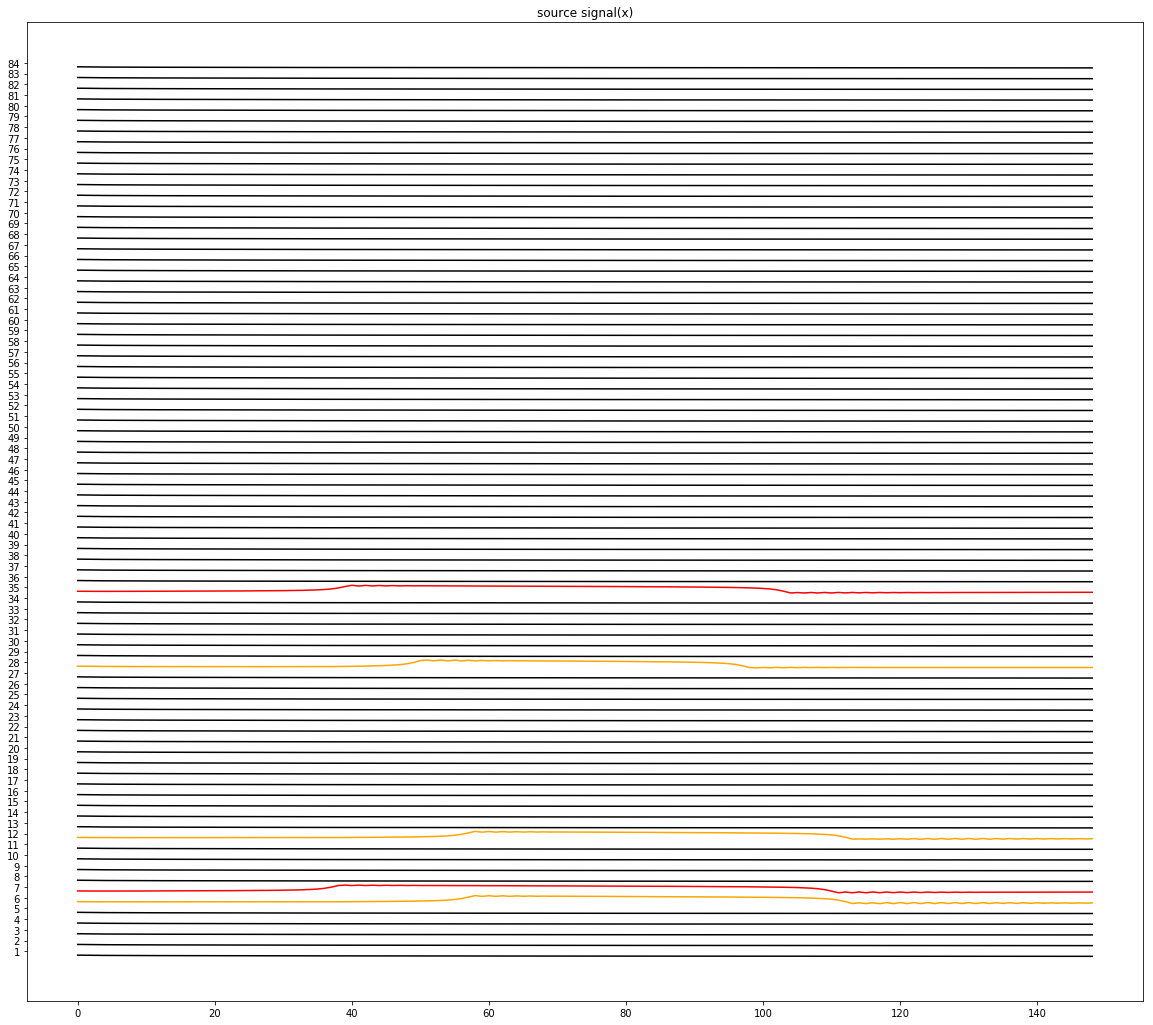

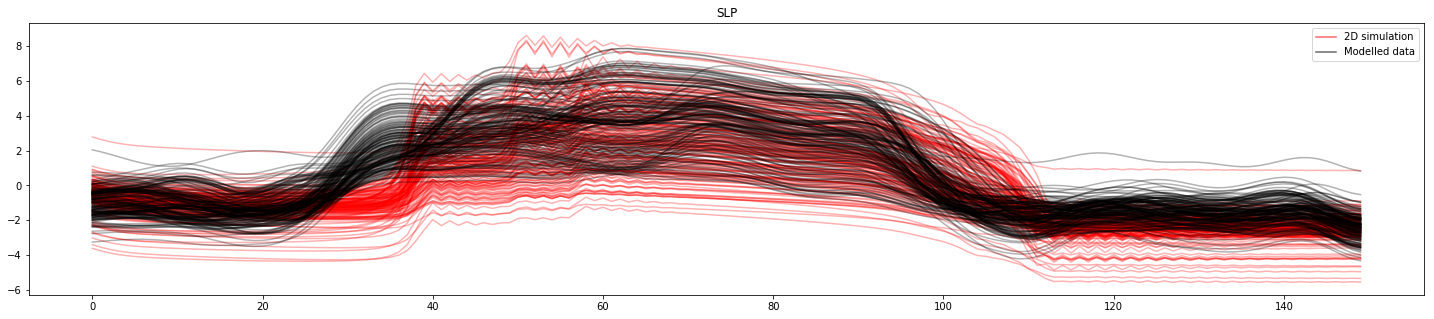

In [25]:
start_idx = 0 #4950
end_idx = -1 #start_idx + 1500

plt.figure(figsize=(20,18))
# plt.plot(sim_out['x'][0,start_idx:end_idx,:]/4.0 + np.r_[0:nn],'k');
# plt.yticks(np.r_[1:nn], np.r_[1:nn])
for i in range(nn):
    if(i in ez):
#         plt.plot(sim_out['x'][0,:,i], color='red')
        plt.plot(sim_out['x'][0,start_idx:end_idx,i]/4.0 + i, color='red');
    elif(i in pz):
#         plt.plot(sim_out['x'][0,:,i], color='orange')
        plt.plot(sim_out['x'][0,start_idx:end_idx,i]/4.0 + i, color='orange');
    else:
#         plt.plot(sim_out['x'][0,:,i], color='black')
        plt.plot(sim_out['x'][0,start_idx:end_idx,i]/4.0 + i, color='black');
plt.title('source signal(x)')
plt.yticks(np.r_[0:nn],np.r_[1:nn+1])
plt.savefig(f'{results_dir}/figures/simulated_source_at_ground_truth.png')

# plt.figure(figsize=(25,5))
# plt.plot(sim_out['seeg'][0,start_idx:end_idx,:],alpha=0.3);
# plt.title('SEEG')

# Computed by optimization
offset = -3.302963
amplitude = 4.41035

plt.figure(figsize=(25,5))
plt.plot(amplitude*(sim_out['slp'][0,...] + offset), alpha=0.3, color='red');
plt.plot(fit_data['fit_trgt'][0:-1:10,:], alpha=0.3, color='black');
plt.title('SLP')
legend_elements = [Line2D([0],[0], color='red', alpha=0.6, label='2D simulation'),
                   Line2D([0],[0], color='black', alpha=0.6, label='Modelled data')]
plt.legend(handles=legend_elements)
plt.savefig(f'{results_dir}/figures/simulated_seeg_at_ground_truth.png')

#### Evaluate the posterior probability at ground truth.

In [ ]:
sim_data = lib.io.stan.rload(f'{results_dir}/Rfiles/sim_data_ground_truth.R')
sim_out = lib.io.stan.read_samples([f'{results_dir}/sim_out_ground_truth.csv'])
fit_data = np.load(f'{data_dir}/CJ_fit_trgt.npz')

nn = sim_data['nn']
ns  = sim_data['ns']
nt = sim_data['nt']
x0 = sim_data['x0']
K = sim_data['K']
x_init = sim_data['x_init']
z_init = sim_data['z_init']
time_step = sim_data['time_step']
tau0 = sim_data['tau0']

# Computed by optimization
offset = -3.302963
amplitude = 4.41035

epsilon_slp = 0.1
epsilon_snsr_pwr = 5.0

slp_true = fit_data['fit_trgt'][0:-1:20,:]
snsr_pwr_true = np.sum(slp_true**2, axis=0)

slp_mean = amplitude*(sim_out['slp'][0,...] + offset)
snsr_pwr_mean = np.sum(slp_mean**2, axis=0)

data = {'nn':nn, 'ns':ns, 'nt':nt, 'x0':x0, 'x_init':x_init, 'z_init':z_init,
        'amplitude':amplitude, 'offset':offset, 'time_step':time_step, 'K':K, 'tau0':tau0,
        'epsilon_slp':epsilon_slp, 'epsilon_snsr_pwr':epsilon_snsr_pwr, 'slp_true':slp_true,
        'snsr_pwr_true':snsr_pwr_true, 'slp_mean':slp_mean, 'snsr_pwr_mean':snsr_pwr_mean}

lib.io.stan.rdump(f'{results_dir}/Rfiles/eval_data_ground_truth.R',data)

In [ ]:
%%bash -s "$results_dir"

RESULTS_DIR=$1

stancompile.sh eval_posterior_prob

./eval_posterior_prob sample num_warmup=0 num_samples=1 \
algorithm=fixed_param data file=${RESULTS_DIR}/Rfiles/eval_data_ground_truth.R output file=${RESULTS_DIR}/eval_out_ground_truth.csv

In [ ]:
eval_out_ground_truth = lib.io.stan.read_samples([f'{results_dir}/eval_out_ground_truth.csv'])

In [ ]:
print(f"posterior probability at ground truth: {eval_out_ground_truth['posterior_prob']}")

#### Evaluate the posterior probability at inferred values
1. Compute the SLP at posterior mean using a forward simulation
2. Evalute posterior at this SLP as mean

#### Step 1

In [ ]:
infer_dir = 'results/exp10/exp10.15'
infer_data = lib.io.stan.read_samples([f'{infer_dir}/samples_epsslp0.10000_epssnsrpwr_5.00000_chain2.csv'])
sim_data = lib.io.stan.rload(f'{infer_dir}/Rfiles/fit_data_snsrfit_ode_epsslp0.10000_epssnsrpwr_5.00000.R')
fit_data = np.load(f'{data_dir}/CJ_fit_trgt.npz')

In [ ]:
ntwrk = np.load(f'{data_dir}/CJ_network.npz')
SC = ntwrk['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain = ntwrk['gain_mat']

nn = sim_data['nn']
ns  = sim_data['ns']
nt = sim_data['nt']
I1 = 3.1
tau0 = np.mean(infer_data['tau0'], axis=0)
x0 = np.mean(infer_data['x0'], axis=0)
time_scale = 1.0
time_step = np.mean(infer_data['time_step'], axis=0)
nsteps = 1 #int(1/time_step)
sigma = 0.0
x_init = np.mean(infer_data['x_init'], axis=0)
z_init = np.mean(infer_data['z_init'], axis=0)
z_eta = np.random.normal(size = (nt, nn))

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'SC':SC, 'gain':gain,
        'x0':x0, 'time_scale':time_scale, 'time_step':time_step, 'nsteps': nsteps,
        'sigma':sigma, 'K':K, 'x_init':x_init, 'z_init':z_init, 'z_eta':z_eta}
lib.io.stan.rdump(f'{results_dir}/Rfiles/sim_data_inferred_params.R',data)

In [ ]:
%%bash -s "$results_dir"

RESULTS_DIR=$1
stancompile.sh vep-forwardsim-2Depileptor

./vep-forwardsim-2Depileptor sample num_warmup=0 num_samples=1 \
algorithm=fixed_param data file=${RESULTS_DIR}/Rfiles/sim_data_inferred_params.R output file=${RESULTS_DIR}/sim_out_inferred_params.csv

In [ ]:
sim_out = lib.io.stan.read_samples([f'{results_dir}/sim_out_inferred_params.csv'])
ez = sim_data_6d['ez']
pz= np.concatenate((sim_data_6d['pz_x0'], sim_data_6d['pz_kplng']))
fit_data = np.load(f'{data_dir}/CJ_fit_trgt.npz')

In [ ]:
start_idx = 0 #4950
end_idx = -1 #start_idx + 1500

plt.figure(figsize=(20,18))
# plt.plot(sim_out['x'][0,start_idx:end_idx,:]/4.0 + np.r_[0:nn],'k');
# plt.yticks(np.r_[1:nn], np.r_[1:nn])
for i in range(nn):
    if(i in ez):
#         plt.plot(sim_out['x'][0,:,i], color='red')
        plt.plot(sim_out['x'][0,start_idx:end_idx,i]/4.0 + i, color='red');
    elif(i in pz):
#         plt.plot(sim_out['x'][0,:,i], color='orange')
        plt.plot(sim_out['x'][0,start_idx:end_idx,i]/4.0 + i, color='orange');
    else:
#         plt.plot(sim_out['x'][0,:,i], color='black')
        plt.plot(sim_out['x'][0,start_idx:end_idx,i]/4.0 + i, color='black');
plt.title('source signal(x)')
plt.yticks(np.r_[0:nn],np.r_[1:nn+1])
plt.savefig(f'{results_dir}/figures/simulated_source_at_inferred_params.png')

# plt.figure(figsize=(25,5))
# plt.plot(sim_out['seeg'][0,start_idx:end_idx,:],alpha=0.3);
# plt.title('SEEG')

amplitude = np.mean(infer_data['amplitude'], axis=0)
offset = np.mean(infer_data['offset'], axis=0)
plt.figure(figsize=(25,5))
plt.plot(amplitude*(sim_out['slp'][0,...] + offset), alpha=0.3, color='red');
plt.plot(fit_data['fit_trgt'][0:-1:20,:], alpha=0.3, color='black');
plt.title('SLP')
legend_elements = [Line2D([0],[0], color='red', alpha=0.6, label='2D simulation'),
                   Line2D([0],[0], color='black', alpha=0.6, label='Modelled data')]
plt.legend(handles=legend_elements)
plt.savefig(f'{results_dir}/figures/simulated_seeg_at_inferred_params.png')

#### Step 2

In [ ]:
infer_res_dir = 'results/exp10/exp10.15'
infer_data = lib.io.stan.read_samples([f'{infer_res_dir}/samples_epsslp0.10000_epssnsrpwr_5.00000_chain2.csv'])
params_data = lib.io.stan.rload(f'{infer_res_dir}/Rfiles/fit_data_snsrfit_ode_epsslp0.10000_epssnsrpwr_5.00000.R')
sim_out = lib.io.stan.read_samples([f'{results_dir}/sim_out_inferred_params.csv'])
fit_data = np.load(f'{data_dir}/CJ_fit_trgt.npz')

nn = params_data['nn']
ns  = params_data['ns']
nt = params_data['nt']
x0 = np.mean(infer_data['x0'], axis=0)
K = np.mean(infer_data['K'], axis=0)
x_init = np.mean(infer_data['x_init'], axis=0)
z_init = np.mean(infer_data['z_init'], axis=0)
time_step = np.mean(infer_data['time_step'], axis=0)
tau0 = np.mean(infer_data['tau0'], axis=0)

amplitude = np.mean(infer_data['amplitude'], axis=0)
offset = np.mean(infer_data['offset'], axis=0)

epsilon_slp = params_data['epsilon_slp']
epsilon_snsr_pwr = params_data['epsilon_snsr_pwr']

slp_true = fit_data['fit_trgt'][0:-1:20,:]
snsr_pwr_true = np.sum(slp_true**2, axis=0)

slp_mean = amplitude*(sim_out['slp'][0,...] + offset)
snsr_pwr_mean = np.sum(slp_mean**2, axis=0)

data = {'nn':nn, 'ns':ns, 'nt':nt, 'x0':x0, 'x_init':x_init, 'z_init':z_init,
        'amplitude':amplitude, 'offset':offset, 'time_step':time_step, 'K':K, 'tau0':tau0,
        'epsilon_slp':epsilon_slp, 'epsilon_snsr_pwr':epsilon_snsr_pwr, 'slp_true':slp_true,
        'snsr_pwr_true':snsr_pwr_true, 'slp_mean':slp_mean, 'snsr_pwr_mean':snsr_pwr_mean}

lib.io.stan.rdump(f'{results_dir}/Rfiles/eval_data_inferred_params.R',data)

In [ ]:
%%bash -s "$results_dir"

RESULTS_DIR=$1

stancompile.sh eval_posterior_prob

./eval_posterior_prob sample num_warmup=0 num_samples=1 \
algorithm=fixed_param data file=${RESULTS_DIR}/Rfiles/eval_data_inferred_params.R output file=${RESULTS_DIR}/eval_out_inferred_params.csv

In [ ]:
eval_out_ground_truth = lib.io.stan.read_samples([f'{results_dir}/eval_out_ground_truth.csv'])
eval_out_inferred_params = lib.io.stan.read_samples([f'{results_dir}/eval_out_inferred_params.csv'])

print(f"Posterior probability at ground truth: {eval_out_ground_truth['posterior_prob']}")
print(f"Posterior probability at inferred parameter values: {eval_out_inferred_params['posterior_prob']}")

In [ ]:
print(amplitude,offset)